In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1,"../models/PyTorch_CIFAR10")

In [3]:
from cifar10_models import vgg


In [4]:
from Torchlurk import Lurk
import torchvision
import torchvision.models as models
from torchvision import transforms
from misc_funcs import clean_bw_imgs,sample_imagefolder,plot_hist,crop_imgs
import jdc
from matplotlib.pyplot import imshow
import dill

In [103]:
from IPython.core.debugger import set_trace
from IPython.display import clear_output

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import ToTensor,ToPILImage
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision import transforms
from PIL import Image
from collections import OrderedDict
import pathlib
import dill


import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle
from copy import deepcopy
from pathlib import Path

from ImageFolderWithPaths import ImageFolderWithPaths
from Projector import Projector

#libraries
sys.path.insert(1, '../lib/pytorch-cnn-visualizations/src/')
from cnn_layer_visualization import CNNLayerVisualization
from layer_activation_with_guided_backprop import GuidedBackprop
from misc_functions import save_gradient_images
from misc_funcs import create_folders,sample_imagefolder,create_labels
from get_models import get_alex_places
from time import perf_counter 
from enum import Enum
import subprocess as sp

In [29]:
State = Enum(
    value='State',
    names=[
        ('idle', 1),
        ('compute top', 2),
        ('compute_top', 2),
        ('compute activ', 3),
        ('compute_activ', 3),
        ('compute grad', 4),
        ('compute_grad', 4)
    ]
)

In [107]:
class Lurk():
    def __init__(self,model,preprocess,labels_path,
                 save_gen_imgs_dir,save_json_path,imgs_src_dir,
                 n_top_avg=3,n_top_max=3,load_json_path=None,side_size=224):
        """
        Lurker class: one lurker can be instanciated per trained pytorch network. Several methods allow to generate various types of data
        concerning the network and can be visualized thanks to the bash command TOCOMPLETE
        Parameters
        ----------
        model : torch.model
            the trained model
        preprocess : torchvision.transforms.transforms.Compose
            the preprocessing used when training the model
        labels_path : string
            path to the file associating the class titles (ex: penguin) to their dirname (ex:n02018795) and their label (ex:724)
        save_gen_imgs_dir : str
            directory where to save the generated images: some subdirectories will be created inside
        save_json_path : string
            path to the json object to create which will stock information for subsequent visualization. Must have an ".json" extension
        imgs_src_dir : string
            directory to the train set of the model
        n_top_avg : int
            how many average images to keep in the top average filter activations
        n_top_max : int
            how many average images to keep in the top maximum filter activations
        load_json_path : string
            path to a previously computed json file: NB the other arguments need to be similar as during this first run. If set to a value,
            the lurker will load the previously computed informations, if set to None, will start a new lurker from scratch
            
        """
        ##################### TODO: get rid of dev#####################
        # allow to run reduced computations
        self.DEVELOPMENT = True
        #number of layers we compute stuff for in development mode
        self.N_LAYERS_DEV = 1
        #number of filters we compute stuff for in development mode
        self.N_FILTERS_DEV = 1
        ###############################################################
        
        #model to compute a lurker for
        self.model = model
        #preprocessing used when training the model
        self.preprocess = preprocess
        self.side_size = side_size
        #state of the lurker: takes values in "idle","compute top","compute activ","compute grad"
        self.state = State.idle

        #path to the labels
        self.LABELS_PATH = labels_path
        #directory where to save the generated images
        self.GEN_IMGS_DIR = save_gen_imgs_dir
        #directory where to load the training images
        self.IMGS_DIR = imgs_src_dir
        
        #where to save the json
        self.JSON_PATH_WRITE = save_json_path
        #number of avg spikes images per filter
        self.N_TOP_AVG = n_top_avg
        # number of max spikes images per filter
        self.N_TOP_MAX = n_top_max
        
        #path to the numb image
        self.NUMB_PATH = "static/data/numb.png"
        
        self.dataset = ImageFolderWithPaths(self.IMGS_DIR,transform=self.preprocess)
        self.data_loader = torch.utils.data.DataLoader(self.dataset, batch_size=1, shuffle=True)
        # each class has 3 kinds of representation: (1)class titles (ex: "penguin") (2) dirname (ex:"n02018795") (3) label (ex:724)
        # CLASS2LAB and LAB2TITLE allow to convert the info from one type to the other
        self.CLASS2LAB = self.dataset.class_to_idx
        labels_infos = self.recreate_labels()
        self.LAB2TITLE = labels_infos.set_index('label')['title'].to_dict()
        
        assert(set(self.LAB2TITLE.keys())==(set(self.CLASS2LAB.values())))
        assert(len(self.LAB2TITLE) == len(self.CLASS2LAB))
        
        if load_json_path is not None:
            # loading information from a previously computed json file
            self.load_from_json(load_json_path)
        else:
            # building the information from scratch
            self.__build_model_info()
        self.save_to_json()
        
        create_folders(self.GEN_IMGS_DIR,["avg_act","avg_act_grad","max_act","max_act_grad","max_act_cropped","max_act_cropped_grad","filt_viz"],self.model_info)
        
        
        self.title_counts = dict(zip(self.LAB2TITLE.values(),[0] *len(self.LAB2TITLE)))
        #initiate the number of counts for the classes
        self.__init_class_counts(self.LAB2TITLE, self.IMGS_DIR,self.title_counts)
    
    
    ################################ Building/Loading ################################
    
    def __build_model_info(self):
        """
        build the model_info from scratch
        """
        model_info = []
        layers = []
        #construct the data structure
        for layer in list(self.model.features.named_children()):
            lay_info = {'id':layer[0],
                      'lay':layer[1],
                      'name':str(layer[1]).split('(')[0] + "_" + str(layer[0]) 
                    }
            if (isinstance(layer[1],(nn.Conv2d,nn.MaxPool2d))):
                layers.append(layer[1])
            if (isinstance(lay_info['lay'],nn.Conv2d)):     
                n_input = lay_info['lay'].in_channels
                n_output = lay_info['lay'].out_channels
                lay_info['n_input'] = n_input
                lay_info['n_output'] = n_output
                lay_info['deproj'] = Projector(deepcopy(layers),224)
                lay_info["filters"] = []
                for i in range(n_output):
                    lay_info["filters"].append({
                        "id":i,
                        "avg_spikes":[0 for i in range(self.N_TOP_AVG)],
                        "avg_imgs":[self.NUMB_PATH for i in range(self.N_TOP_AVG)],
                        "avg_imgs_grad":[self.NUMB_PATH for i in range(self.N_TOP_AVG)],
                        "max_spikes":[0 for i in range(self.N_TOP_MAX)],
                        "max_slices":[[[0,0],[0,0]]for i in range(self.N_TOP_MAX)],
                        "max_imgs":[self.NUMB_PATH for i in range(self.N_TOP_MAX)],
                        "max_imgs_crop":[self.NUMB_PATH for i in range(self.N_TOP_MAX)],
                        "max_imgs_grad":[self.NUMB_PATH for i in range(self.N_TOP_MAX)],
                        "max_imgs_crop_grad":[self.NUMB_PATH for i in range(self.N_TOP_MAX)],
                        "filter_viz":self.NUMB_PATH,
                        "histo_counts_max":OrderedDict(zip(self.LAB2TITLE.values(),[0] *len(self.LAB2TITLE))),
                        "histo_counts_avg":OrderedDict(zip(self.LAB2TITLE.values(),[0] *len(self.LAB2TITLE)))
                    })
            elif (type(lay_info['lay']) == nn.Linear):
                    n_input = lay_info['lay'].in_features
                    n_output = lay_info['lay'].out_features
                    lay_info['n_output'] = n_output
                    #lay_info["filters"] = [empty_filter.copy() for i in range(n_output)]
            model_info.append(lay_info)
            self.model_info = model_info
            self.conv_layinfos = [lay_info for lay_info in self.model_info if isinstance(lay_info['lay'],nn.Conv2d)]
            
    def set_state(self,state):
        self.state = state
        with open(self.JSON_PATH_WRITE, 'r+') as f:
            data = json.load(f)
            data['state'] = self.state.name
            f.seek(0)        
            json.dump(data, f, indent=2)
            f.truncate()

    def save_to_json(self):
        """
        save the json information of self.model_info
        """
        model_info2 = deepcopy(self.model_info)
        for lay_info in model_info2:
            if (isinstance(lay_info['lay'],nn.Conv2d)):
                del lay_info['deproj']
            del lay_info['lay']
        with open(self.JSON_PATH_WRITE, 'w') as fout:
            model_info2 = {'state':self.state.name,'infos':model_info2}
            json.dump(model_info2, fout, indent = 2)
        print("json saving done!")
        
    def load_from_json(self,load_path):
        """
        load from json information
        """
        layers = []
        with open(load_path, 'r') as fin:
            model_info = json.load(fin)['infos']
        for lay_info,layer in zip(model_info,self.model.features):
            lay_info['lay'] = layer
            if (isinstance(layer,(nn.Conv2d,nn.MaxPool2d))):
                layers.append(layer)
            if (isinstance(layer,nn.Conv2d)):
                lay_info['deproj'] = Projector(deepcopy(layers),224)
        self.model_info = model_info
        self.conv_layinfos = [lay_info for lay_info in self.model_info if isinstance(lay_info['lay'],nn.Conv2d)]
        self.__check_imgs_exist()
        print("Loading done!") 
    
        
    def save_to_dill(self,path):
        """
        save to dill format: similar to pickle format,but handle additional data formats
        """
        torch.save(self,path, pickle_module=dill)
        print("dill saving done!")
        
        

    @staticmethod
    def load_from_dill(load_path,overwrite=False,alternate_json_path=None):
        """
        load the lurker from a dill (pickle-like) file
        Args:
            load_path(str): path to the dill file
            overwrite(Bool): whether to overwrite the JSON the lurker reads from
            alternate_path(str): only valid if overwrite is set to False: specific path to the write json
        """
        assert(not (overwrite and alternate_json_path is not None))
        lurker = torch.load(load_path, pickle_module=dill)
        if not overwrite:
            if alternate_json_path is None:
                path = Path(lurker.JSON_PATH_WRITE)
                name = path.stem + "_copy"
                lurker.JSON_PATH_WRITE = str(path.with_name(name).with_suffix(".json"))
            else:
                path = Path(alternate_json_path)
                assert(path.is_file() and path.suffix == ".json")
                lurker.JSON_PATH_WRITE = alternate_json_path
        lurker.__check_imgs_exist()
        print("Loading done!") 
        return lurker    
    
    def __check_imgs_exist(self): 
        """
        check that all the images in the json file indeed exist and are at the right position when loading
        """
        try:
            type_keys = ["avg_imgs","avg_imgs_grad","max_imgs","max_imgs_grad"]
            for lay_info in self.conv_layinfos:
                for filtr in lay_info['filters']:
                    for key in type_keys:
                        for el in filtr[key]:
                            Path(el).resolve(strict=True)
                    Path(filtr["filter_viz"]).resolve(strict=True)
        except FileNotFoundError as e:
            print("Non coherent path in the loaded object:{}".format(e.filename))
            
    
    ################################ Practical ################################

            
    def __get_filt_dir(self,dir_type,layer_name,filter_id):
        """
        return the path to the appropriate folder
        Parameters
        ----------
        dir_type : str
            One of "avg_act","avg_act_grad","max_act","max_act_grad","max_act_cropped","max_act_cropped_grad","filt_viz"
        layer_name : str
            name of the layer
        filter_id : int/str
            index of the filter
        """
        return os.path.join(self.GEN_IMGS_DIR,dir_type,str(layer_name),str(filter_id))
    
    def __extract_name(self,img_path,ext='.jpg'):
        """
        extract the name of the imgpath and add the extension
        ex:
        >>> __extract_name("path/to/file.txt")
        return: file.jpg
        """
        jpg_name = img_path.split("/")[-1]
        img_name = jpg_name.split(".")[0] + ext
        return img_name
    
    ################################################################ Generated images ################################################################

    ################################ average/maximum activation images ################################
    def compute_top_imgs(self,verbose = False,compute_max=True,compute_avg=True,save_loc=False):
        """
        compute the average and max images for all the layers of the model_info such that each filter of each layer knows what are
        its favourite images (write down the link to the avg/max images in the json)
        """
        self.set_state(State.compute_top)
        t_start = perf_counter()  
        assert(compute_max or compute_avg)
        self.__reset_histos()
        for j,(datas,labels,paths) in enumerate(self.data_loader):
            print("Progression update favimgs:{:.2f} %".format(j/len(self.data_loader) * 100))
            for i,lay_info in enumerate(self.model_info):
                clear_output(wait=True)
                if verbose:
                    print("AvgMax update:{}/{}:{:.2f} %..".format(i,len(self.model_info),100*j/ len(data_loader)))

                #datas: Batchsize x Numberfilter x Nout x Nout
                datas = lay_info['lay'](datas)
                if (not isinstance(lay_info['lay'],nn.Conv2d) ):
                    continue
                if (i >=self.N_LAYERS_DEV and self.DEVELOPMENT):
                    break

                batch_size = datas.size(0)
                filter_nb = datas.size(1)
                width = datas.size(3)

                #spikes: Batchsize x Filternumber
                max_spikes,max_pos = datas.view([batch_size,filter_nb,-1]).max(dim = 2)
                max_rows = max_pos / width
                max_cols = max_pos % width

                avg_spikes = datas.view([batch_size,filter_nb,-1]).mean(dim = 2)
                if compute_max:
                    self.__update_filters_max_imgs(lay_info,max_spikes,paths,max_rows,max_cols,labels)
                if compute_avg:
                    self.__update_filters_avg_imgs(lay_info,avg_spikes,paths,labels)
                #save the whole model
                t_now = perf_counter()
                if (t_now - t_start > 5):
                    t_start = t_now
                    self.save_to_json()

        self.__normalize_histos()
        self.__sort_filters_spikes()
        if save_loc:
            self.__save_avgmax_imgs()
        self.__save_cropped()
        self.set_state(State.idle)
        self.save_to_json()

        
    def __save_avgmax_imgs(self):
        """
        save the maximum average/maximum activation for each filter from the trainin set
        """
        for lay_info in self.conv_layinfos:
            for filtr in lay_info['filters']:
                for agg in ["avg","max"]:
                    for i,src_path in enumerate(filtr["{}_imgs".format(agg)]):
                        new_dir = Path(self.__get_filt_dir("{}_act".format(agg),lay_info["name"],filtr["id"]))
                        name = Path(src_path).name
                        new_path= new_dir.joinpath(name)
                        #we open the path pointing to the training set
                        im = Image.open(src_path)
                        im.save(new_path)
                        filtr["{}_imgs".format(agg)][i] = new_path
                    
    def __sort_filters_spikes(self):
        """
        sorts the spikes and respective paths of the filters inplace
        """
        for lay_info in self.conv_layinfos:
            for filtr in lay_info['filters']:
                max_indx = np.argsort(filtr["max_spikes"])[::-1]
                filtr["max_spikes"] = np.array(filtr["max_spikes"])[max_indx].tolist()
                filtr["max_imgs"] = np.array(filtr["max_imgs"])[max_indx].tolist()
                filtr["max_slices"] = np.array(filtr["max_slices"])[max_indx].tolist()

                avg_indx = np.argsort(filtr["avg_spikes"])[::-1]
                filtr["avg_spikes"] = np.array(filtr["avg_spikes"])[avg_indx].tolist()
                filtr["avg_imgs"] = np.array(filtr["avg_imgs"])[avg_indx].tolist()
    

    def __update_filters_max_imgs(self,lay_info,batch_spikes,paths,max_rows,max_cols,labels):
        #as many spikes in batch_spikes as there are samples in batch
        for spikes,path,label,rows,cols in zip(batch_spikes,paths,labels,max_rows,max_cols):
            #at this stage there are as many spike in spikes as there are filters
            for k,(filt,spike,row,col) in enumerate(zip(lay_info["filters"],spikes.detach().numpy(),rows,cols)):
                #compute the histogram with maximal values
                filt["histo_counts_max"][self.LAB2TITLE[label.item()]] += float(spike)
                #compute the minimum spike for the filter
                min_indx = np.argmin(filt["max_spikes"])
                min_spike = min(filt["max_spikes"])
                
                if (spike > min_spike and not (path in filt["max_imgs"])):
                    ((x1,x2),(y1,y2)) = lay_info["deproj"].chain(((row.item(),row.item()),(col.item(),col.item())))
                    assert(isinstance(x1,int) and isinstance(x2,int) and isinstance(y1,int) and isinstance(y2,int))
                    filt["max_slices"][min_indx] = ((x1,x2),(y1,y2))
                    filt["max_imgs"][min_indx] = path
                    filt["max_spikes"][min_indx] = float(spike)
                    
    def __update_filters_avg_imgs(self,lay_info,batch_spikes,paths,labels):
        #as many spikes in batch_spikes as there are samples in batch
        for spikes,path,label in zip(batch_spikes,paths,labels):
            #at this stage there are as many spike in spikes as there are filters
            for k,(filt,spike) in enumerate(zip(lay_info["filters"],spikes.detach().numpy())):
                #compute the histogram with avg values
                filt["histo_counts_avg"][self.LAB2TITLE[label.item()]] += float(spike)
                #compute the minimum spike for the filter
                min_indx = np.argmin(filt["avg_spikes"])
                min_spike = min(filt["avg_spikes"])
                if (spike > min_spike and not (path in filt["avg_imgs"])):
                    filt["avg_imgs"][min_indx] = path
                    filt["avg_spikes"][min_indx] = float(spike)
                

    def __save_cropped(self,grad = False,verbose=False):
        """
        iterate on the model_info to save a cropped version of the images
        Args:
            grad(Bool): whether to save the gradients versions
        """
        ext = "_grad" if grad else ""
        filtrlist = "max_imgs{}".format(ext)
        folder = "max_act_cropped{}".format(ext)
        filtrtargetlist = "max_imgs_crop{}".format(ext)

        for i,lay_info in enumerate(self.conv_layinfos):
            clear_output(wait=True)
            if verbose:
                print("Progression:{} %".format(i/len(conv_layinfos)*100))
            for filtr in lay_info['filters']:
                for i,(src_path,slices) in enumerate(zip(filtr[filtrlist],filtr['max_slices'])):
                    if (src_path == self.NUMB_PATH):
                        continue
                    src_path = Path(src_path)
                    target_dir = Path(self.__get_filt_dir(folder,lay_info['name'],filtr['id']))
                    file_name = src_path.name
                    target_path = target_dir.joinpath(file_name)
                    
                    image = ToTensor()(Image.open(src_path))
                    ((x1,x2),(y1,y2)) = slices
                    cropped = image[:,x1:x2+1,y1:y2+1]
                    ToPILImage()(cropped).save(str(target_path))
                    filtr[filtrtargetlist][i] = str(target_path)
                    
    ################################ Histograms related ################################

    def recreate_labels(self,output_path=None):
        """
        recreate the label files wrt to a specific dataset with potentially less classes than the original one. 
        Useful for smaller computations
        """
        #set_trace()
        if output_path is None:
            output_path = str(Path(self.IMGS_DIR).parent.joinpath("labels2.txt"))
        infos = pd.read_csv(self.LABELS_PATH,sep=" ",header=None)
        infos.columns = ['dir_name','label','title']
        infos.set_index('dir_name',inplace=True,drop=False)
        new_infos= infos.loc[self.dataset.class_to_idx.keys()].copy()
        new_infos.label = new_infos.dir_name.map(self.dataset.class_to_idx)
        new_infos.drop(columns=['dir_name']).to_csv(output_path,header=None,sep=" ")
        return new_infos
            
            
    def __init_class_counts(self,indx_to_title,src_path,obj):
        """
        create the dictionary which counts the number of images per classes in the dataset
        """
        for subfold in os.listdir(src_path):
            subfold_path = os.path.join(src_path,subfold)
            count = len([name for name in os.listdir(subfold_path)])
            title = indx_to_title[self.CLASS2LAB[subfold]]
            obj[title] += count
            
    def __reset_histos(self):
        """
        reset the counts for the histograms counts
        """
        for lay_info in self.conv_layinfos:
            for filt in lay_info['filters']:
                filt['histo_counts_max'] = dict(zip(self.LAB2TITLE.values(),[0] *len(self.LAB2TITLE)))
                filt['histo_counts_avg'] = dict(zip(self.LAB2TITLE.values(),[0] *len(self.LAB2TITLE)))
            
    def __normalize_histos(self):
        """
        average the counts of the histograms wrt to the number of samples in the classes of the dataset
        """
        for lay_info in self.conv_layinfos:
            for filt in lay_info['filters']:
                for key in filt['histo_counts_max'].keys():
                    filt['histo_counts_max'][key] /= self.title_counts[key]
                for key in filt['histo_counts_avg'].keys():
                    filt['histo_counts_avg'][key] /= self.title_counts[key]
                filt['histo_counts_max'] = OrderedDict(sorted(filt['histo_counts_max'].items(),key = lambda x: x[1])[::-1])
                filt['histo_counts_avg'] =  OrderedDict(sorted(filt['histo_counts_avg'].items(),key = lambda x: x[1])[::-1])
                

                    
    ################################ Layer visualizations ################################
                    
    def compute_viz(self,num_imgs_per_class=None,ratio_imgs_per_class=None):
        """
        Compute the filter visualization for all classes
        Args:
            num_imgs_per_class(int): number of filters to compute the visualization for for each class
            ratio_imgs_per_class(float): ratio of filters to compute the visualization for for each class
        """
        self.set_state(State.compute_activ)
        checks = [num_imgs_per_class is None , ratio_imgs_per_class is None]
        assert(sum(checks)==1 or sum(checks)==0)
        for lay_indx,lay_info in self.conv_layinfos:
            print("Layer {}:".format(lay_indx))
            N = lay_info["lay"].out_channels
            indexes = np.arange(N)
            np.random.shuffle(indexes)
            if checks[0]:
                indexes = indexes[:num_imgs_per_class]
            elif checks[1]:
                lim = int(ratio_imgs_per_class * N)
                indexes = indexes[:lim]
            self.compute_layer_viz(lay_indx,indexes)
        self.set_state(State.idle)


    def compute_layer_viz(self,layer_indx,filter_indexes = None):
        """
        compute  and save the filter maximal activation as an image. Compute it only for filters for which
        it has not been computed yet: you need to delete the existing image if you wish for a refresh.
        Args:
            layer_indx(int): layer to compute the filter for
            filter_indexes(list(int)):  list of filter to compute the visualization for
        """
        self.set_state(State.compute_activ)
        lay_info = self.model_info[layer_indx]
        if filter_indexes is None:
            filter_indexes = range(lay_info["lay"].out_channels)
        else:
            for i in filter_indexes:
                if (i >= lay_info["lay"].out_channels or i<0):
                    raise IndexError("filter_indexes must have lower value than layer output number.")
        layer_name = lay_info["name"]
        pre_existing = []
        for filt in lay_info["filters"]:
            name = "{}_{}_max_activ.jpg".format(lay_info['name'],filt['id'])
            filt_path = self.__get_filt_dir("filt_viz",lay_info["name"],filt["id"])
            filt_path = os.path.join(filt_path,name)
            try:
                f = open(filt_path)
                filt["filter_viz"] = filt_path
                pre_existing.append(filt["id"])
                f.close()
            except FileNotFoundError:
                pass

        filter_indexes = [i for i in filter_indexes if i not in pre_existing]

        for j,filt_indx in enumerate(filter_indexes):
            print("Filter {} / {}".format(j+1,len(filter_indexes)))
            filt = lay_info['filters'][filt_indx]
            visualizer = CNNLayerVisualization(self.model.features, 
                                               selected_layer=int(lay_info['id']), 
                                               selected_filter=filt_indx,
                                               side_size=self.side_size)
            act_max_img = visualizer.visualise_layer_with_hooks()
            filt_path = self.__get_filt_dir("filt_viz",lay_info['name'],filt['id'])
            name = "{}_{}_max_activ.jpg".format(lay_info['name'],filt['id'])
            filt_path = os.path.join(filt_path,name)
            #save the image
            ToPILImage()(act_max_img).save(filt_path)
            print("Vis saved!")
            filt["filter_viz"] = filt_path
            self.save_to_json()
        print("Visualization done!")
        self.set_state(State.idle)
        self.save_to_json()


        
    ################################ Gradients ################################

    def compute_grads(self,verbose = False,compute_avg = True,compute_max = True):
        """
        compute the gradients for the fav images of all filters of all layers for the model_info
        Args:
            model_info (dic): as described above
            origin_path (str): path where to store the folders containing the gradient images
        """
        self.set_state(State.compute_grad)
        gbp = GuidedBackprop(self.model)
        for i,lay_info in enumerate(self.conv_layinfos):
            if (i >= self.N_LAYERS_DEV and self.DEVELOPMENT):
                break
            for j,filt in enumerate(lay_info['filters']):
                clear_output(wait=True)
                if (self.DEVELOPMENT):
                    print("Grads Progression:layer{}/{} {}%".format(i+1,self.N_LAYERS_DEV,j/self.N_FILTERS_DEV*100))
                    if (j >=self.N_FILTERS_DEV):
                        break
                else:
                    print("Grads Progression:layer{}/{} {}%".format(i+1,len(self.model_info),j/len(lay_info['filters'])*100))
                if compute_avg:
                    path = self.__get_filt_dir("avg_act_grad",lay_info['name'],filt["id"])
                    self.__compute_grads_filt(gbp,filt,path,lay_info['id'],"avg_imgs")
                if compute_max:
                    path = self.__get_filt_dir("max_act_grad",lay_info['name'],filt["id"])
                    self.__compute_grads_filt(gbp,filt,path,lay_info['id'],"max_imgs")
                    self.__save_cropped(grad= True)
        self.set_state(State.idle)

    def __compute_grads_filt(self,gbp,filt,path,lay_id,img_type):
        """
        compute the gradients wrt to the favourite images of a filter filt.
        Args:
            gbp (GuidedBackprop): fitted on the model
            filt (dic): filter from a layer
            path (str): path to the folder where to store the gradient images
            img_type (str): either "avg_imgs" or "max_imgs"
        """
        grad_strindx = "avg_imgs_grad" if img_type == "avg_imgs" else "max_imgs_grad"

        for i,img_path in enumerate(filt[img_type]):
            if (img_path == self.NUMB_PATH):
                continue   

            #name of the image
            img_name = self.__extract_name(img_path,"_grad.jpg")
            #joined path and imagename
            grad_path = os.path.join(path,img_name)

            try:
                f = open(grad_path)
                filt[grad_strindx][i] = grad_path
                f.close()
                continue
            except FileNotFoundError:
                pass

            image = Image.open(img_path)
            image = self.preprocess(image).unsqueeze(0)
            image.requires_grad = True
            class_name = img_path.split("/")[-1].split("_")[0]
            gradient = gbp.generate_gradients(image,self.CLASS2LAB[class_name],lay_id,filt['id'])
            #normalization of the gradient
            gradient = gradient - gradient.min()
            gradient /= gradient.max()
            im = ToPILImage()(gradient[0])
            im.save(grad_path)
            filt[grad_strindx][i] = grad_path
            
    ################################ Plotting ################################

    def plot_hist(self,layer_indx,filt_indx,hist_type="max"):
        """
        layer_indx(int): index of the layer
        filt_indx(int): index of the filter
        hist_type(str): either "max" or "avg": which hist to plot
        """
        assert(hist_type == "max" or hist_type == "avg")
        lay_info = self.model_info[layer_indx]
        assert(isinstance(lay_info['lay'],nn.Conv2d))
        filt = lay_info['filters'][filt_indx]
        obj = filt['histo_counts_max'] if hist_type == "max" else filt['histo_counts_avg']
        fig,ax = plt.subplots(1,1,figsize=(10,20))
        ax.barh(list(obj.keys())[::-1],list(obj.values())[::-1])

    def plot_filter_viz(self,layer_indx,filt_indx):
        """
        plot the filter visualization
        Parameters:
        -----------
        layer_indx : int
            index of the layer
        filt_indx : int
            index of the filter
        """
        filt = self.conv_layinfos[layer_indx]['filters'][filt_indx]
        im = Image.open(filt["filter_viz"])
        plt.imshow(np.asarray(im))

    def plot_top(self,kind,layer_indx,filt_indx,add_grad=False):
        """
        plot the top activation samples of the train set for a given filter
        Parameters:
        -----------
        kind : str
            either "avg" or "max"
        layer_indx : int
            index of the layer
        filt_indx : int
            index of the filter
        add_grad : bool
            whether to plot the corresponding gradients below the original image
        """
        filt = self.conv_layinfos[layer_indx]['filters'][filt_indx]
        imgs = filt['{}_imgs'.format(kind)]
        N = len(imgs)
        if add_grad:
            imgs = imgs + filt["{}_imgs_grad".format(kind)]
        M = 2 if add_grad else 1
        fig,axes = plt.subplots(M,N,figsize=(10,10))
        for i,(ax,img) in enumerate(zip(axes.flatten(),imgs)):
            im_pil = Image.open(img)
            ax.imshow(np.asarray(im_pil))
    def plot_crop(self,layer_indx,filt_indx,grad=False):
        """
        plot the top max images along with the cropped version which leads to the highest activating output for the given filter
        Parameters:
        -----------
        layer_indx : int
            index of the layer
        filt_indx : int
            index of the filter
        grad : bool
            whether to plot grad or the original image
        """ 
        key = "max_imgs"
        key_crop = "max_imgs_crop" 
        if grad:
            key += "_grad"
            key_crop += "_grad"
        filt = self.conv_layinfos[layer_indx]['filters'][filt_indx]
        imgs = filt[key]
        crop_imgs = filt[key_crop]
        fig,axes = plt.subplots(2,len(imgs),figsize=(10,10))
        for i,(ax,img) in enumerate(zip(axes.flatten(),imgs+crop_imgs)):
            im_pil = Image.open(img)
            ax.imshow(np.asarray(im_pil))
        ################################ Serving ################################
    def serve(self,port=5000):
        self.p = sp.Popen([sys.executable, '../app.py','--port',str(port)], 
                                    stdout=sp.PIPE, 
                                    stderr=sp.STDOUT)
    def end_serve(self):
        self.p.terminate()

# ImageNet

At that stage, Download the tinyimagenet dataset on [this link](https://www.kaggle.com/ifigotin/imagenetmini-1000#n01440764_10470.JPEG) and place it in the directory data (s.t the path looks like `data/tinyimagenet/rest_of_path`

First we center-crop the images to the desired shape

In [7]:
crop_imgs("../bigdata/imagenet-mini/train/")

Progression:2.70%


KeyboardInterrupt: 

Once the dataset is downloaded, we need to get rid of a few buggy bw images: 

In [142]:
clean_bw_imgs("../bigdata/imagenet-mini/train/")

Progression:100.00%
BW files found:
../data/imagenet-mini/train/n03920288/n03920288_3315.JPEG
../data/imagenet-mini/train/n03920288/n03920288_3629.JPEG
../data/imagenet-mini/train/n03942813/n03942813_1800.JPEG
../data/imagenet-mini/train/n02791270/n02791270_16505.JPEG
../data/imagenet-mini/train/n02791270/n02791270_23048.JPEG
../data/imagenet-mini/train/n02950826/n02950826_11905.JPEG
../data/imagenet-mini/train/n02950826/n02950826_13787.JPEG
../data/imagenet-mini/train/n02894605/n02894605_26115.JPEG
../data/imagenet-mini/train/n03782006/n03782006_37777.JPEG
../data/imagenet-mini/train/n04041544/n04041544_1401.JPEG
../data/imagenet-mini/train/n02403003/n02403003_656.JPEG
../data/imagenet-mini/train/n02109047/n02109047_1579.JPEG
../data/imagenet-mini/train/n02109047/n02109047_6125.JPEG
../data/imagenet-mini/train/n02787622/n02787622_5870.JPEG
../data/imagenet-mini/train/n02787622/n02787622_9908.JPEG
../data/imagenet-mini/train/n02102480/n02102480_6584.JPEG
../data/imagenet-mini/train/n03

You might want to work on a subset of tinyimagenet for computations reason.

In [12]:
sample_imagefolder("../bigdata/imagenet-mini/train/","../static/data/imagenet10classes/images",num_dir=20,img_num_per_dir=5)

Progression:95.00%
Sampling terminated.


In [108]:
model = models.vgg16(pretrained=True)
# same preprocess used as vgg16
preprocess = transforms.Compose([
    transforms.CenterCrop(224), 
    transforms.ToTensor()
    ,transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Run this cell if you want to create the information for the first time.

In [109]:
#watch out: once you chose a folder name for the computed images and a json name, the json name will point to that folder name exclusively.
lurker = Lurk(model,
              preprocess,
              labels_path="../bigdata/imagenet-mini/labels_imagenet.txt",
              save_gen_imgs_dir='../static/results/vgg16_imagenet/',
              save_json_path='../static/saved_model/vgg16_imagenet.json',
              imgs_src_dir="../static/data/imagenet10classes/images/",
              side_size=224)

json saving done!


How to serve the website

In [117]:
lurker.serve()

In [118]:
lurker.end_serve()

How to save/load the lurker in a convenient manner.. \[OPTIONNAL\]

In [22]:
lurker.save_to_dill("../generated/vgg16_imagenet.pickle")


lurker = Lurk.load_from_dill("../generated/vgg16_imagenet.pickle")

KeyboardInterrupt: 

## Computations

We compute the average/maximum activation images from the train set:

In [62]:
lurker.compute_top_imgs()

json saving done!


And plot the "most activating" classes w.r.t a metric(max or avg) for a given filter

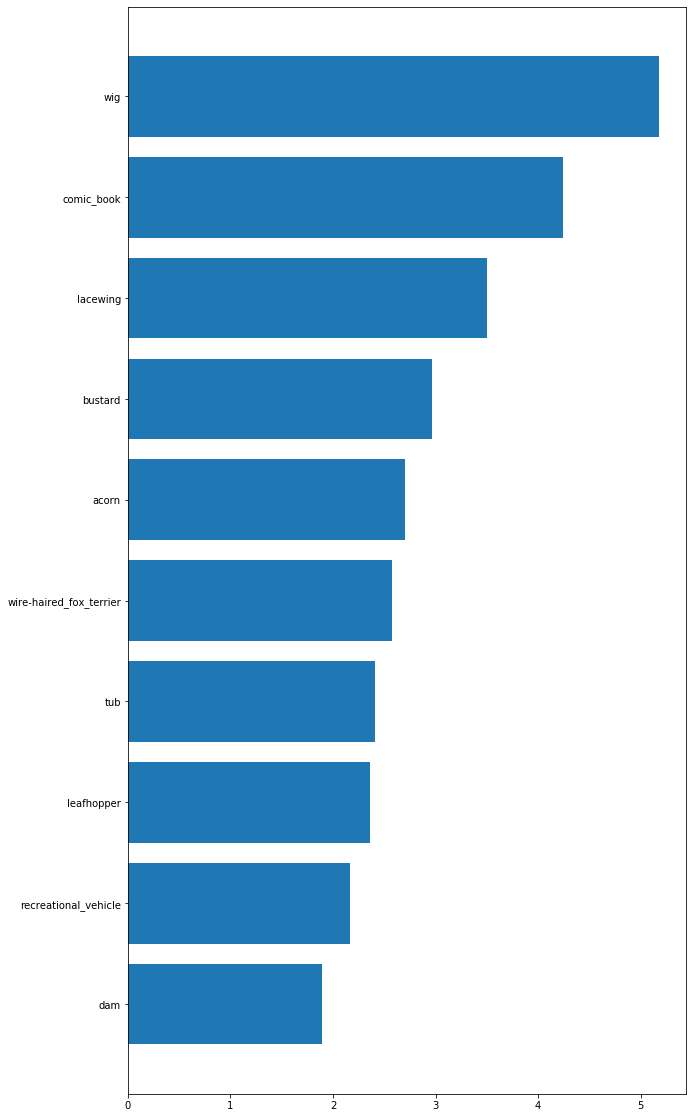

In [122]:
lurker.plot_hist(0,0,"max")

Possibility to compute the layer visualization:

In [129]:
lurker.compute_layer_viz(layer_indx = 0,filter_indexes=[6,7])

Visualization done!


And the respective gradients w.r.t the most activating images

In [27]:
lurker.compute_grads()

Grads Progression:layer1/1 100.0%
json saving done!


If you wish to load a precomputed json, just add the `load_path` attribute. Watch out, it needs to be coherent with the folder name.\[OPTIONNAL\]

In [30]:
lurker3 = Lurk(model,
               preprocess,
               labels_path="../bigdata/imagenet-mini/labels_imagenet.txt",
               save_gen_imgs_dir='../results/trash/',
               save_json_path='../saved_model/new_vgg16.json',
               imgs_src_dir="../data/imagenet10classes/images",
               load_json_path='../saved_model/vgg16_imagenet.json',
               side_size=224)

Loading done!


# Places365

TODO: not available yet 

Download of the images possible on http://places2.csail.mit.edu/download.html

In [ ]:
alex_places = get_alex_places()

places_preprocess = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

lurker_alex_places = Lurk(alex_places
                          ,places_preprocess
                          ,labels_path="../data/places365/labels.txt"
                          ,save_gen_imgs_dir='../results/alex_places/'
                          ,save_json_path='../saved_model/alex_places.json'
                          ,imgs_src_dir="../data/places365/images/"
                          ,side_size=256)

# Cifar10

In [143]:
#download the big dataset
cifar_dataset = torchvision.datasets.CIFAR10("../bigdata/CIFAR10_dataset", train=True, transform=None, target_transform=None, download=True)

Files already downloaded and verified


In [144]:
# takes ~ 5min
#convert_to_jpg_dirs(cifar_dataset,"../bigdata/CIFAR10")

Progression:100.00 %


In [181]:
sample_imagefolder("../bigdata/CIFAR10/","../data/CIFAR10/images",num_dir=10,img_num_per_dir=10)

Progression:90.00%
Sampling terminated.


In [182]:
create_labels(cifar_dataset.class_to_idx,"../data/CIFAR10/labels_cifar.txt")

In [183]:
preprocess_cif = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
model_cif = vgg.vgg11_bn(pretrained=True)

In [184]:
lurker_cif = Lurk(model_cif,
                  preprocess_cif,
                  labels_path="../data/CIFAR10/labels_cifar.txt",
                  save_gen_imgs_dir='../results/cifar/',
                  save_json_path='../saved_model/cifar.json',
                  imgs_src_dir="../data/CIFAR10/images/",
                  side_size=32)

In [189]:
lurker_cif.compute_top_imgs()

lurker_cif.plot_hist(0,0,"max")

lurker_cif.compute_layer_viz(layer_indx = 0,filter_indexes=[6,7])

lurker_cif.compute_grads()

TODO:
- Representation of a Lurk